# Analysis of data of HTML Lesson

In this notebook we will analyse the data from the lesson about HTML given on 10th of December 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, re

PRIOR_PATH = 'real_data/ac/1-survey__p1__ac-quiz-4gkv/product.json'
SPLIT_PATH = 'real_data/op/create-groups__op-create-groups-2mly/product.json'
GROUP_PATH = 'real_data/op/create-groups__op-create-groups-dloz/product.json'
EX1_PATH = 'real_data/ac/3-exercise-1__p1__ac-autocode-eln2/product.json'
EX2_PATH = 'real_data/ac/5-exercise-2__p1__ac-autocode-3lgn/product.json'
EX3_PATH = 'real_data/ac/7-exercise-3__p1__ac-autocode-5cby/product.json'
EX4_PATH = 'real_data/ac/9-coding__p2__ac-autocode-c98k/product.json'

RESULT_PATH = "results/"

## Metadata

First we will collect metadata about students it consists of their prior knoledge about HTML and the group they belong during the experiment.

In [2]:
def load_json(path):
    with open(path) as file:
        return json.load(file)

def get_prior_knowledge(data):
    payload = data['payload']
    res = {k: v['data']['answersIndex'] for k, v in payload.items()}
    return pd.DataFrame(res, index=['q1', 'q2', 'q3', 'q4']).T

In [3]:
prior_data_dict = load_json(PRIOR_PATH)
prior_data = get_prior_knowledge(prior_data_dict)

In [4]:
def prior_level(x):
    if x['q2'] == 0:
        if x['q3'] == 0:
            x['level'] = 'High'
        else:
            x['level'] = 'Medium'
    else:
        x['level'] = 'Low'
    return x

prior_data = prior_data.apply(prior_level, axis=1)
prior_data.level = pd.Categorical(prior_data.level, 
                   categories=["Low", "Medium", "High"],
                   ordered=True)

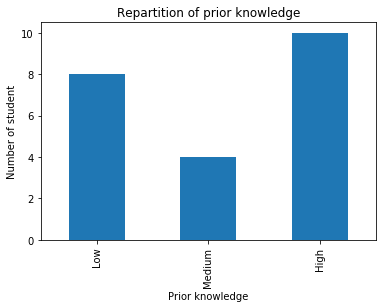

In [5]:
plt.figure()
prior_data.level.value_counts().sort_index().plot.bar()
plt.title("Repartition of prior knowledge")
plt.xlabel("Prior knowledge")
plt.ylabel("Number of student")
plt.savefig(RESULT_PATH+'prior_knowledge.eps')
plt.show()

In [6]:
SPLIT_PATH = 'real_data/op/create-groups__op-create-groups-2mly/product.json'
split_dict = load_json(SPLIT_PATH)
split_dict = split_dict['socialStructure']['Split class into two groups']

In [7]:
def group(x, split_dict):
    if x.name in split_dict['1']:
        x['group'] = 1
    else:
        x['group'] = 2
    return x

prior_data = prior_data.apply(group, axis=1, args=[split_dict])
meta = prior_data[['level', 'group']]
meta.head()

,level,group
28AYQLYnkgBi5uKXN,High,2
2bcTjnfNuKp5hJcyK,Low,1
53TwXKQe62kT2tnRp,High,2
Aw4gxBApCsdMueCwk,High,2
BMjGCT4wEQuYNyTiS,High,1


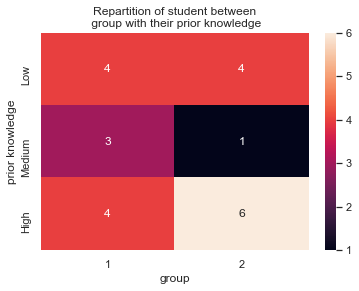

In [8]:
import seaborn as sb
sb.set_context("notebook")
sb.set()


meta_pivoted = pd.pivot_table(meta.rename(columns={'level':'prior knowledge'}), index='prior knowledge', columns='group', aggfunc=len)
meta_pivoted = meta_pivoted.reset_index()
meta_pivoted['prior knowledge'] = pd.Categorical(meta_pivoted['prior knowledge'], categories=["Low", "Medium", "High"], ordered=True)
meta_pivoted = meta_pivoted.sort_values(by="prior knowledge").set_index("prior knowledge", drop = True)


fig, ax = plt.subplots()

ax = sb.heatmap(meta_pivoted,annot=True)

# Bugfix to show whole first and last row
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Repartition of student between\n group with their prior knowledge")
plt.savefig(RESULT_PATH+'repartition_prior.eps')
plt.show()

In [9]:
print("Number of participants : ", len(meta))

Number of participants :  22


We can see that the group are well balanced

## Getting results for each test

In [10]:
result = pd.DataFrame()

In [11]:
def get_exercise_results(data):
    payload = data['payload']
    res = {k: v['data']['code'] for k, v in payload.items()}
    return pd.Series(res)

In [12]:
# html_clean_comments = re.compile(r"<!--(.*?)-->")
# html_clean_spaces
regex_html_comments = r"<!--(.*?)-->"
regex_html_tags = r"<\/?(?:html|head|title|body|section|h[1-6]|p|blockquote|ul|li|a|img)[^<>]*>"
html_cleaned = re.sub(regex_html_comments, "", "<!--sljaæflasjg--><h1 href='sdfljel'>ælsdjfaljfio</h1> <!-- læsfj --> <p>sjklgs<a></a><p>")
html_cleaned = re.sub(regex_html_comments, "", "<!DOCTYPE html> <!-- INSERT YOUR MARKUP BELOW --> <html><header><title>This is title</title></header><body>Hello world</body></html>")
html = re.findall(regex_html_tags, html_cleaned, re.I)
html

def findElements(text):
    regex_html_comments = r"<!--(.*?)-->"
    regex_html_tags = r"<\/?(?:html|head|title|body|section|h[1-6]|p|blockquote|ul|li|a|img)[^<>]*>"
    html_cleaned = re.sub(regex_html_comments, "", text)
    return re.findall(regex_html_tags, html_cleaned, re.I)

### Test 1

In [13]:
##EX1
##test function 
def testElement(openTag,closeTag,positionOpen,positionClose,indiceList,listElements,score):
    #verify exist
    if (openTag in listElements):
        score[indiceList] = 1
    if (closeTag in listElements):
        score[indiceList+1] = 1
    #verify position
    if abs(positionOpen) < len(listElements):
        if (listElements[positionOpen] == openTag):
            score[indiceList+2] = 1
    if abs(positionClose) < len(listElements):
        if (listElements[positionClose] == closeTag):
            score[indiceList+3] = 1
    #remove tag if exist
    if (openTag in listElements):  
        listElements.remove(openTag)
    if (closeTag in listElements):
        listElements.remove(closeTag)
    return [listElements,score]

def testEx1(text):
    listElements = findElements(text)
    score = []
    for i in range(16):
        score.append(0)  
    testElement("<html>","</html>",0,-1,0,listElements,score)    
    testElement("<head>","</head>",0,3,4,listElements,score) 
    testElement("<title>","</title>",0,1,8,listElements,score) 
    testElement("<body>","</body>",0,1,12,listElements,score)
    return sum(score)/len(score)


In [14]:
ex1_dict = load_json(EX1_PATH)
ex1 = get_exercise_results(ex1_dict)
result['ex1'] = ex1.apply(testEx1)

### Test 2

In [15]:
def removeOldElementsEx1(listElements):
    listElements.remove('<html lang="en">')
    listElements.remove('<head>')
    listElements.remove('<title>')
    listElements.remove('</title>')
    listElements.remove('</head>')
    listElements.remove('<body>')
    listElements.remove('<section>')
    listElements.remove('</section>')
    listElements.remove('</body>')
    listElements.remove('</html>')
    return listElements

def testEx2(text):
    listElements = findElements(text)
    score = []
    for i in range(32):
        score.append(0)  
    listElements = removeOldElementsEx1(listElements)
    testElement("<h1>","</h1>",0,1,0,listElements,score) 
    testElement("<h2>","</h2>",0,1,4,listElements,score) 
    testElement("<p>","</p>",0,1,8,listElements,score)
    testElement("<blockquote>","</blockquote>",0,1,12,listElements,score) 
    testElement("<p>","</p>",0,1,16,listElements,score)
    testElement("<h2>","</h2>",0,1,20,listElements,score)
    testElement("<p>","</p>",0,1,24,listElements,score)
    testElement("<p>","</p>",0,1,28,listElements,score)
    print(score)
    return sum(score)/len(score)

In [16]:
ex2_dict = load_json(EX2_PATH)
ex2 = get_exercise_results(ex2_dict)
result['ex2'] = ex2.apply(testEx2)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Test 3

In [17]:
def removeOldElementsEx2(listElements):
    listElements = removeOldElementsEx1(listElements)
    
    listElements.remove('<h1>')
    listElements.remove('</h1>')
    listElements.remove('<h2>')
    listElements.remove('</h2>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    listElements.remove('<blockquote>')
    listElements.remove('</blockquote>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    listElements.remove('<h2>')
    listElements.remove('</h2>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    
    return listElements

def testEx3(text):
    listElements = findElements(text)
    score = []
    for i in range(36):
        score.append(0)  
    listElements = removeOldElementsEx2(listElements)
    testElement("<p>","</p>",0,1,0,listElements,score) 
    testElement("<ul>","</ul>",0,9,4,listElements,score) 
    testElement("<li>","</li>",0,3,8,listElements,score)
    testElement('<a href="https://en.wikipedia.org/wiki/HTML">',"</a>",0,1,12,listElements,score) 
    
    if ("<a>" in listElements):  
        listElements.remove("<a>")
        
    testElement("<li>","</li>",0,1,16,listElements,score)
    testElement("<li>","</li>",0,1,20,listElements,score)
    testElement("<p>","</p>",0,3,24,listElements,score)
    testElement('<a href="https://en.wikipedia.org/wiki/Tim_Berners-Lee">',"</a>",0,1,28,listElements,score)
    testElement('<img alt="Tim’s original proposal" src="https://tinyurl.com/yxdkbbbj">', '<img alt="Tim Berners-Lee" src="https://tinyurl.com/yyjstlro">',0,1,32,listElements,score)
    print(score)
    return sum(score)/len(score)

In [18]:
ex3_dict = load_json(EX3_PATH)
ex3 = get_exercise_results(ex3_dict)
result['ex3'] = ex3.apply(testEx3)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 

### Test Final

In [19]:
def removeOldElementsFinal(listElements):
    listElements.remove('<html lang="en">')
    listElements.remove('<head>')
    listElements.remove('<title>')
    listElements.remove('</title>')
    listElements.remove('</head>')
    listElements.remove('<section>')
    listElements.remove('</section>')
    listElements.remove('</html>')
    listElements.remove('<li>')
    listElements.remove('</li>')
    listElements.remove('<li>')
    listElements.remove('</li>')
    listElements.remove('<li>')
    listElements.remove('</li>')
    listElements.remove('<p>')
    listElements.remove('</p>')
    if '</a>' in listElements:
        listElements.remove('</a>')
    if '</a>' in listElements:
        listElements.remove('</a>')
    if '</a>' in listElements:
        listElements.remove('</a>')

    return listElements
    
def testFinal(text):
    listElements = findElements(text)

    score = []
    for i in range(21):
        score.append(0)  
    listElements = removeOldElementsFinal(listElements)

    
    #1. Closing tag </body> missing
    testElement("<body>","</body>",0,-1,0,listElements,score) 
    
    #2. Order of headings
    testElement("<h1>","</h1>",0,1,4,listElements,score)
    if ("<h2>" in listElements):  
        listElements.remove("<h2>")
    if ("</h2>" in listElements):
        listElements.remove("</h2>")
    if ("<h3>" in listElements):  
        listElements.remove("<h3>")
    if ("</h3>" in listElements):
        listElements.remove("</h3>")
    if ("<h2>" in listElements):  
        listElements.remove("<h2>")
    if ("</h2>" in listElements):
        listElements.remove("</h2>")
    if ("<h3>" in listElements):  
        listElements.remove("<h3>")
    if ("</h3>" in listElements):
        listElements.remove("</h3>")

    
    #3. Closing tag </p> missing
    testElement("<p>","</p>",0,1,8,listElements,score)

    
    #5. <ul> missing
    testElement("<ul>","</ul>",0,4,12,listElements,score)

    
    #4. <a> is required to have href attribute
    if ("<a>" in listElements):
        listElements.remove("<a>")
    else:
        score[16] = 1
        if listElements:
            listElements.pop(0)
    if ("<a>" in listElements):
        listElements.remove("<a>")
    else:
        score[17] = 1
        if listElements:
            listElements.pop(0)
    if ("<a>" in listElements):
        listElements.remove("<a>")
    else:
        score[18] = 1
        if listElements:
            listElements.pop(0)

    #6. <img> src broken    #7. alt attribute missing
    if ('<img src="https://media-cdn.tripadvisor.com/media/photo-s/05/15/db/23/rolex-learning-center.jp">' in listElements):
        score[19] = 0
        score[20] = 0
        listElements.remove('<img src="https://media-cdn.tripadvisor.com/media/photo-s/05/15/db/23/rolex-learning-center.jp">')
    elif ('<img src="https://media-cdn.tripadvisor.com/media/photo-s/05/15/db/23/rolex-learning-center.jpg">' in listElements):
        score[19] = 1
        score[20] = 0
        listElements.remove('<img src="https://media-cdn.tripadvisor.com/media/photo-s/05/15/db/23/rolex-learning-center.jpg">')
    else:
        score[19] = 1
        score[20] = 1
        
    print(score)
    return sum(score)/len(score)

In [20]:
ex4_dict = load_json(EX4_PATH)
ex4 = get_exercise_results(ex4_dict)
final_result = ex4.apply(testFinal)

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]


In [21]:
groups_dict = load_json(GROUP_PATH)
groups_dict = groups_dict['socialStructure']['Split class into groups of 2-3 for the HTML analysis']
group = pd.Series(groups_dict).explode()

In [22]:
final_results = pd.merge(group.rename("id"), final_result.rename('final'), left_index=True, right_index=True)

In [23]:
results = pd.merge(result, final_results, left_index=True, right_on='id')
results = results.set_index('id')
results

,ex1,ex2,ex3,final
id,,,,
28AYQLYnkgBi5uKXN,0.9375,1.00000,0.611111,0.666667
2bcTjnfNuKp5hJcyK,0.1250,0.62500,0.000000,0.428571
53TwXKQe62kT2tnRp,0.6875,0.56250,0.083333,0.523810
Aw4gxBApCsdMueCwk,0.7500,0.25000,0.083333,0.523810
BMjGCT4wEQuYNyTiS,0.7500,0.43750,0.222222,0.476190
C23vEwAz5F76NjERx,1.0000,0.87500,0.888889,0.809524
EdAtNnM345PRb4tLZ,0.0000,0.00000,0.000000,0.571429
Gv7QyY2nyFbAQadHu,0.2500,0.68750,0.000000,0.809524
NEJpZWwLZ4dzzvYh7,0.6875,0.46875,0.444444,0.571429


In [24]:
results = pd.merge(results, meta, left_index=True, right_index=True)

## Analysis of the results

Let's just analyse the results.

In [25]:
results

,ex1,ex2,ex3,final,level,group
28AYQLYnkgBi5uKXN,0.9375,1.00000,0.611111,0.666667,High,2
2bcTjnfNuKp5hJcyK,0.1250,0.62500,0.000000,0.428571,Low,1
53TwXKQe62kT2tnRp,0.6875,0.56250,0.083333,0.523810,High,2
Aw4gxBApCsdMueCwk,0.7500,0.25000,0.083333,0.523810,High,2
BMjGCT4wEQuYNyTiS,0.7500,0.43750,0.222222,0.476190,High,1
C23vEwAz5F76NjERx,1.0000,0.87500,0.888889,0.809524,High,2
Gv7QyY2nyFbAQadHu,0.2500,0.68750,0.000000,0.809524,Medium,1
NEJpZWwLZ4dzzvYh7,0.6875,0.46875,0.444444,0.571429,Medium,1
PqdvC3XWpMyWFqire,0.2500,0.12500,0.277778,0.523810,Low,2
PrjgtRBCGbqJoZ3HN,0.7500,0.87500,0.527778,0.761905,Low,1


In [26]:
results.to_csv('results.csv')

In [42]:
video = results[results.group == 2]['ex2']
video = video.append(results[results.group == 1]['ex3'])
video = pd.DataFrame(video)
video['group'] = "VIDEO"
video

,0,group
28AYQLYnkgBi5uKXN,1.000000,VIDEO
53TwXKQe62kT2tnRp,0.562500,VIDEO
Aw4gxBApCsdMueCwk,0.250000,VIDEO
C23vEwAz5F76NjERx,0.875000,VIDEO
PqdvC3XWpMyWFqire,0.125000,VIDEO
QpTfa3muPPMBFR9Pp,0.875000,VIDEO
YvCdYm3zReNZzrtNs,0.875000,VIDEO
iCcqC5LHLXf5Ja3jK,0.250000,VIDEO
xGGhgoi8Lr67HZvga,0.250000,VIDEO
znza2WvWyiBTfdzab,1.000000,VIDEO


In [43]:
self_discovery = results[results.group == 1]['ex2']
self_discovery = self_discovery.append(results[results.group == 2]['ex3'])
self_discovery = pd.DataFrame(self_discovery)
self_discovery['group'] = "SELF DISCOVERY"
self_discovery

,0,group
2bcTjnfNuKp5hJcyK,0.625000,SELF DISCOVERY
BMjGCT4wEQuYNyTiS,0.437500,SELF DISCOVERY
Gv7QyY2nyFbAQadHu,0.687500,SELF DISCOVERY
NEJpZWwLZ4dzzvYh7,0.468750,SELF DISCOVERY
PrjgtRBCGbqJoZ3HN,0.875000,SELF DISCOVERY
Sp3JZtnPt2G6W7a32,0.875000,SELF DISCOVERY
Ystaypp7AmJ4wYvsM,0.500000,SELF DISCOVERY
bFNGRyeEysDF8YCYG,0.187500,SELF DISCOVERY
hjfHvYz88HrEAiHw7,0.750000,SELF DISCOVERY
k2oxfxXXwQszGYgbX,1.000000,SELF DISCOVERY


In [46]:
combined_results = video.append(self_discovery)

In [56]:
combined_results = combined_results.rename(columns={0:'score'})
combined_results.to_csv('combined_results.csv')

### Results by group

In [28]:
group_results = results.groupby(['level', 'group']).mean()
group_results['number'] = results.groupby(['level', 'group'])['final'].count()
group_results

ex1       ex2       ex3     final  number
level  group                                                
High   1      0.437500  0.531250  0.527778  0.666667       4
       2      0.843750  0.687500  0.541667  0.682540       6
Low    1      0.578125  0.812500  0.354167  0.607143       4
       2      0.578125  0.562500  0.541667  0.547619       4
Medium 1      0.562500  0.677083  0.444444  0.730159       3
       2      0.750000  0.250000  0.083333  0.714286       1

In [29]:
group_results_std = results.groupby(['level', 'group']).std()
group_results_std

ex1       ex2       ex3     final
level  group                                        
High   1      0.239357  0.340419  0.224525  0.134687
       2      0.151812  0.279508  0.371330  0.133560
Low    1      0.351244  0.161374  0.248840  0.179758
       2      0.311979  0.438986  0.406670  0.119839
Medium 1      0.272431  0.203325  0.444444  0.137464
       2           NaN       NaN       NaN       NaN

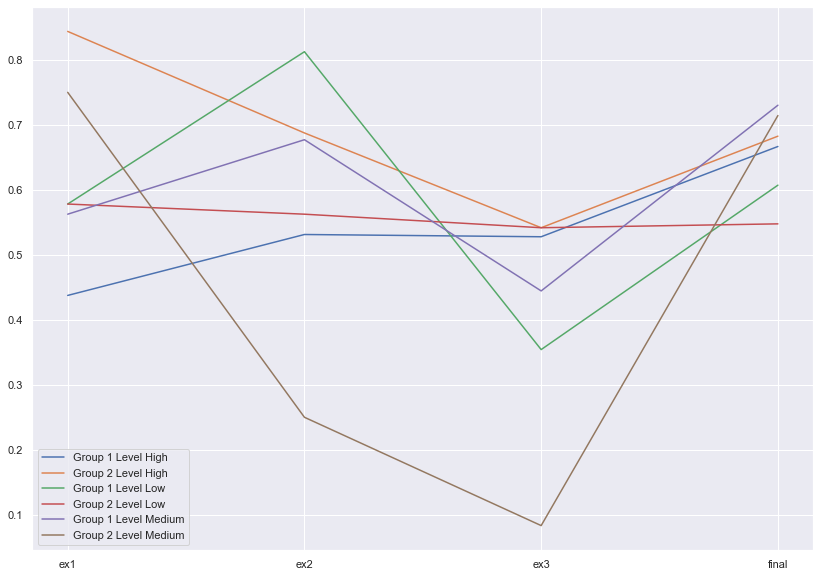

In [30]:
plt.figure(figsize=(14,10))
for idx, group in group_results.iterrows():
    
    group = group.drop(index=['number'])
    plt.plot(group.index, group.tolist(), label="Group {} Level {}".format(idx[1], idx[0]))
plt.legend()

In [31]:
group_results = results.groupby('group').mean()
group_results['number'] = results.groupby('group')['final'].count()
group_results_std = results.groupby('group').std()
group_results

,ex1,ex2,ex3,final,number
group,,,,,
1,0.522727,0.673295,0.441919,0.662338,11
2,0.738636,0.602273,0.500000,0.636364,11


[0.6732954545454546, 0.4419191919191918]
[0.2582103507361251, 0.28149034187720523]
[0.6022727272727273, 0.5]
[0.33804669526829895, 0.37101795237920004]


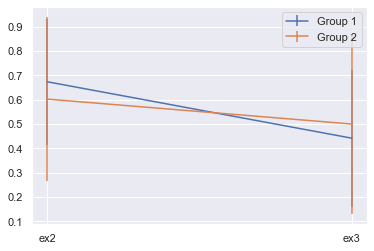

In [32]:
plt.figure()
for idx, group in group_results.iterrows():
    
    group = group.drop(index=['number','ex1', 'final'])
    print(group.tolist())
    print(group_results_std.iloc[idx-1, 1:3].tolist())
    plt.errorbar(group.index, group.tolist(), label="Group {}".format(idx), yerr=group_results_std.iloc[idx-1, 1:3].tolist())
plt.legend()
plt.savefig('meangroup.png')

Ex3 is harder than Ex2 so it is normal that people have lower points.
But we can remark that people from group 2 has lower points on ex2 and higher on ex3.

Group 2 had first the video and then the self discovery lecture while group1 had first the self discovery lecture and then the video.

So if we just look at the mean for each group we can say that the MOOC performs less thant the self discovery lecture

### Boxplot

Let's look at the boxplot

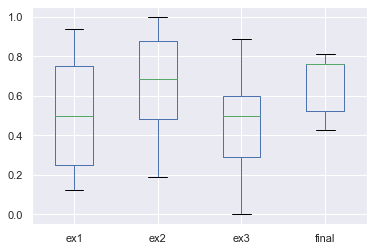

In [33]:
results[results.group == 1].drop(columns='group').boxplot()

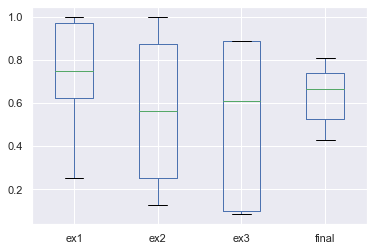

In [34]:
results[results.group == 2].drop(columns='group').boxplot()

In [35]:
results

,ex1,ex2,ex3,final,level,group
28AYQLYnkgBi5uKXN,0.9375,1.00000,0.611111,0.666667,High,2
2bcTjnfNuKp5hJcyK,0.1250,0.62500,0.000000,0.428571,Low,1
53TwXKQe62kT2tnRp,0.6875,0.56250,0.083333,0.523810,High,2
Aw4gxBApCsdMueCwk,0.7500,0.25000,0.083333,0.523810,High,2
BMjGCT4wEQuYNyTiS,0.7500,0.43750,0.222222,0.476190,High,1
C23vEwAz5F76NjERx,1.0000,0.87500,0.888889,0.809524,High,2
Gv7QyY2nyFbAQadHu,0.2500,0.68750,0.000000,0.809524,Medium,1
NEJpZWwLZ4dzzvYh7,0.6875,0.46875,0.444444,0.571429,Medium,1
PqdvC3XWpMyWFqire,0.2500,0.12500,0.277778,0.523810,Low,2
PrjgtRBCGbqJoZ3HN,0.7500,0.87500,0.527778,0.761905,Low,1


In [36]:
group_results_std.iloc[1, 1:3]

ex2    0.338047
ex3    0.371018
Name: 2, dtype: float64